### 0. 데이터 불러오기
https://drive.google.com/file/d/1M8KwdmGm8EWCn_IEWAcctbUJBww-M3cF/view?usp=sharing

1. 위 링크에 있는 zip 파일을 '드라이브에 바로가기 추가'하기(안되면 그냥 다운로드 후 내 드라이브에 업로드)
2. GPU 설정 후, 드라이브 마운트
3. zip 파일 풀기 (약 2분 소요)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!unzip -uq “압축을 풀 zip 파일의 경로” -d “압축을 풀고자 하는 폴더의 경로”
!unzip -uq /content/drive/MyDrive/plant-leaf-dataset.zip -d /content/drive/MyDrive/plant-leaf-dataset

### 1. 데이터 분할을 위한 디렉토리 생성

In [4]:
import os
import shutil

original_dataset_dir = '/content/drive/MyDrive/plant-leaf-dataset/plant-leaf-dataset' #데이터셋이 위치한 경로 지정  
classes_list = os.listdir(original_dataset_dir) #해당 경로 하위에 있는 모든 폴더의 목록을 가져옴(폴더 목록 == 클래스 목록)
 
base_dir = '/content/drive/MyDrive/plant-leaf-dataset/plant-leaf-new-dataset' #train/val/test로 분할한 데이터를 저장할 폴더 생성
os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'train') #train 폴더 생성
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'val') #validation 폴더 생성
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test') #test 폴더 생성
os.mkdir(test_dir)

for cls in classes_list: #train/val/test 폴더에 각각 클래스 목록 폴더를 생성    
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

FileExistsError: ignored

### 2. train/validation/test 데이터 분할 및 클래스 별 데이터 수 확인

In [4]:
import math
for cls in classes_list: #모든 클래스에 대한 작업 반복
    path = os.path.join(original_dataset_dir, cls) 
    fnames = os.listdir(path) #path 위치에 존재하는 모든 이미지 파일의 목록을 fnames에 저장
    
    #train/validation/test 의 비율을 6:2:2로 (데이터 규모에 따라 조정 가능)
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    #train
    train_fnames = fnames[:train_size] #train 데이터에 해당하는 파일의 이름을 train_fnames에 저장
    for fname in train_fnames: #train 데이터에 대해 for문의 내용 반복
        src = os.path.join(path, fname) #복사할 원본 파일의 경로 지정
        dst = os.path.join(os.path.join(train_dir, cls), fname) #복사한 후 저장할 파일의 경로 지정
        shutil.copyfile(src, dst) #src의 경로에 해당하는 파일을 dst의 경로에 지정
    
    #validation
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    #test    
    test_fnames = fnames[(train_size + validation_size):(test_size + validation_size + train_size)]
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

    print("class(",cls,") Train:",len(train_fnames), "Validation:",len(validation_fnames), "Test:",len(test_fnames))

class( Apple___healthy ) Train: 987 Validation: 329 Test: 329
class( Grape___healthy ) Train: 253 Validation: 84 Test: 84
class( Grape___Black_rot ) Train: 708 Validation: 236 Test: 236
class( Peach___Bacterial_spot ) Train: 1378 Validation: 459 Test: 459
class( Potato___healthy ) Train: 91 Validation: 30 Test: 30
class( Potato___Early_blight ) Train: 600 Validation: 200 Test: 200
class( Corn___Common_rust ) Train: 715 Validation: 238 Test: 238
class( Strawberry___Leaf_scorch ) Train: 671 Validation: 223 Test: 223
class( Apple___Apple_scab ) Train: 378 Validation: 126 Test: 126
class( Strawberry___healthy ) Train: 273 Validation: 91 Test: 91
class( Peach___healthy ) Train: 216 Validation: 72 Test: 72
class( Corn___healthy ) Train: 697 Validation: 232 Test: 232


### 3. 기본 설정

In [117]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available() #GPU 사용 가능한지 확인하는 메서드(사용할 수 있으면 TRUE, 없으면 FALSE 반환)
print(USE_CUDA)
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") #DEVICE 변수에 TRUE 이면 cuda를 FALSE 이면 cpu를 저장
print(DEVICE)

BATCH_SIZE = 512 #배치사이즈 지정
EPOCH = 5 #에포크 지정

import torchvision.transforms as transforms
data_transforms = { # transforms.Compose()는 이미지 전처리, Augmentation 등 사용, Augmentation이란? 좌우 반전, 밝기 조절, 이미지 확대 등 노이즈를 주어 더 강한 모델을 만들어 주는 기법
    'train': transforms.Compose([transforms.Resize([64,64]), # Resize -> 이미지의 크기를 64x64로 조정                    
                                 transforms.RandomHorizontalFlip(), #RandomHorizontalFlip -> 이미지를 무작위로 좌우 반전
                                 transforms.RandomVerticalFlip(), #RandomVerticalFlip -> 이미지를 무작위로 상하 반전
                                 transforms.RandomCrop(52), #RandomCrop -> 이미지의 일부를 랜덤하게 잘라서 52x52 사이즈로 변경
                                 transforms.ToTensor(), # ToTensor -> 이미지를 텐서 형태로 변환하고, 모든 값을 0~1 사이로 변경
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]), #Normalize ->정규화를 위해선 평균값과 표준편차값이 필요
                                                                                                        #            첫번째[]는 R,G,B 채널 값에서 정규화를 적용할 평균값 
                                                                                                        #            두번째[]는 R,G,B 채널 값에서 정규화를 적용할 표준편차값 
                                                                                                        #            이 값은 이미지넷 데이터의 값이고, 정규화는 Local Minimum에 빠지는 것을 방지
    'val': transforms.Compose([transforms.Resize([64,64]), 
                               #validation data는 Augmentation에 해당하는 부분을 제외하고 동일하게 전처리 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

True
cuda


### 4. 데이터 로더

In [5]:
from torchvision.datasets import ImageFolder #이미지 데이터는 하나의 클래스가 하나의 폴더에 대응되기 때문에 데이터셋을 불러올 때 ImageFolder를 사용

# ImageFolder로 데이터셋 불러오기 -> root : 데이터 불러 올 경로 설정, transform : 앞서 설정한 전처리 방법 지정(불러오기 편하게 딕셔너리 형태로 구성)
image_datasets = {x: ImageFolder(root=os.path.join(base_dir, x), transform=data_transforms[x]) for x in ['train', 'val']} 

# DataLoader로 불러온 이미지 데이터를 주어진 조건에 따라 미니 배치 단위로 분리 -> shuffle=True : 데이터의 순서가 섞여 학습시에 Label 정보의 순서를 기억하는 것을 방지 할 수 있음 필수!
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']} 

#train/validation의 총 개수를 저장
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#12개 클래스의 목록을 저장
class_names = image_datasets['train'].classes

print(class_names)
print(len(class_names))

['Apple___Apple_scab', 'Apple___healthy', 'Corn___Common_rust', 'Corn___healthy', 'Grape___Black_rot', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy']
12


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 5. 전이학습 모델 불러오기
1. 모델만 불러와서 구조 print 해보기
2. 분류층 바꾸고 print 해보기

In [20]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=faf00f27a31cb9fb84557f03c96c0485366cf3c9d96b041c174268d9e739f43a
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [139]:
from torchvision import models #pytorch 공식문서에서 확인 한 것처럼, 여기서 여러 모델을 불러올 수 있음
import torch.nn as nn
import torch.optim as optim

from efficientnet_pytorch import EfficientNet
'''
#resnet18/34/50 
model = models.resnet50(pretrained=True) #pretrained=True로 설정하면 pre-trained model의 parameter값을 그대로 가져옴, False로 설정하면 모델의 아키텍처만 가져오고 parameter는 랜덤 설정
num_ftrs = model.fc.in_features #모델의 마지막 레이어의 입력 채널의 수를 저장(in_features는 해당 레이어의 입력 채널 수를 의미)   
model.fc = nn.Linear(num_ftrs, len(class_names)) #모델의 마지막 레이어를 새로운 레이어로 교체 (입력 채널 수는 기존 레이어와 동일, 출력 채널 수를 우리가 원하는 수로 설정하는 것! 여기서는 클래스 수 12개) 


#vgg16/19
model = models.vgg16(pretrained=True)
model.classifier[6].out_features = len(class_names) #마지막 레이어를 교체하는 방법이 약간 다름, print 해서 구조 확인하면서 이해

#mobilenet_v2
model = models.mobilenet_v2(pretrained=True)
#model.classifier[1].out_features = len(class_names)

#mobilnet_v3_small
model = models.mobilenet_v3_small(pretrained=True)
#model.classifier[3].out_features = len(class_names)

#googlenet
model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

'''
#efficientnet_b0
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=12)


model = model.to(DEVICE) #모델 gpu에 태우기
print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dS

### 6. Layer Freeze

In [140]:
cnt = 0 #몇 번째 Layer인지 나타내는 변수 cnt 설정

for child in model.children(): #모델의 모든 Layer 정보를 담고 있음 (vgg, mobilenet 계열은 model.features)
    cnt += 1 
    #import pdb;pdb.set_trace() #디버거 cnt,n,c,child,q
    if cnt < 4: #resnet50기준 10개의 Layer중 1~5개는 Freeze하고, 6~10은 학습 시 parameter를 업데이트 하도록!
        print(child)
        for param in child.parameters(): #vgg, mobilenet 계열은 model.features.parameters()
            param.requires_grad = False  #False -> NO UPDATE(FREEZE), True -> UPDATE(기본값)


Conv2dStaticSamePadding(
  3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
)
BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
ModuleList(
  (0): MBConvBlock(
    (_depthwise_conv): Conv2dStaticSamePadding(
      32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_se_reduce): Conv2dStaticSamePadding(
      32, 8, kernel_size=(1, 1), stride=(1, 1)
      (static_padding): Identity()
    )
    (_se_expand): Conv2dStaticSamePadding(
      8, 32, kernel_size=(1, 1), stride=(1, 1)
      (static_padding): Identity()
    )
    (_project_conv): Conv2dStaticSamePadding(
      32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
      (static_padding): Identity()
    )
    (_bn2): Batc

### 7. 손실함수, 최적화함수, 스케쥴러 설정
- Adam vs SGD
- learning rate는 작게!
- 미리 학습 코드까지 실행!

In [141]:
#모델 학습에 사용하는 Loss 함수를 지정
criterion = nn.CrossEntropyLoss()

#Optimizer는 Adam, filter와 lambda를 사용하는 이유 : param.requires_grad = True로 설정된 Layer의 parameter만을 업데이트 하기 위해서!
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005) #전이학습 시에는 lr 낮게(과적합 방지)
 
from torch.optim import lr_scheduler
# 에포크에 따라 Learning Rate를 변경하는 역할 (7 에포크마다 0.1씩 곱해 LR을 감소시킴), Why? : 학습 보폭을 정하는 일은 매우 중요한데, 처음엔 크게 -> 학습 진행될 수록 작게 설정하는 것이 좋다고 알려짐, but 아직 연구중
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 6. 모델 학습 및 저장

In [142]:
# 전이학습 모델 학습 및 검증
import time
import copy
import matplotlib.pyplot as plt
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    train_losses , train_accuracy = [],[] #그래프 그리기 위해서 train에 대한 loss,accuracy 저장
    val_losses , val_accuracy = [],[] #그래프 그리기 위해서 validation에 대한 loss,accuracy 저장
    best_model_wts = copy.deepcopy(model.state_dict())  #정확도가 가장 높은 모델을 저장
    best_acc = 0.0 #정확도가 가장 높은 모델의 정확도 저장
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time() #한 에포크 돌 때 소요되는 시간 측정(시작 시각 저장)                                    
        for phase in ['train', 'val']: #한 에포크 돌 때 train 한 번, validation 한 번씩 각각 진행
            if phase == 'train': 
                model.train() #train이면 학습 모드
            else:
                model.eval() #validation이면 평가 모드(평가 때 사용하지 말아야 할 작업들 알아서 꺼줌, dropout이나 batchnorm layer 같은 것들)     
 
            running_loss = 0.0   #모든 데이터의 loss를 합해서 저장
            running_corrects = 0 #정확하게 예측한 경우의 수를 저장

            for inputs, labels in dataloaders[phase]: #모델의 현재 모드(train or validation)에 해당하는 Dataloader에서 데이터를 받는 for문
                inputs = inputs.to(DEVICE) #데이터를 gpu에 태움 
                labels = labels.to(DEVICE) #데이터의 라벨값을 gpu에 태움
                
                optimizer.zero_grad() #학습 진행하면 이전 Batch의 Gradient값이 Optimizer에 저장될 것이므로 초기화 해주고 시작해야 함
                
                with torch.set_grad_enabled(phase == 'train'): #set_grad_enabled를 이용하면 train 모드에서만 모델의 Gradient를 업데이트 하도록 설정 할 수 있음
                    outputs = model(inputs) #드디어 데이터를 모델에 입력!
                    _, preds = torch.max(outputs, 1) #모델에 입력된 데이터가 12개의 클래스에 속할 확률값 출력, 이 중 가장 높은 값의 인덱스를 예측값으로 preds에 저장
                    loss = criterion(outputs, labels) #모델의 예측값과 정답값 사이의 Loss를 계산(criterion 함수는 위에서 미리 설정해 둔 것)
    
                    if phase == 'train':   
                        loss.backward() #계산한 loss값을 이용하여 BackPropagation을 통해 계산한 Gradient값을 parameter에 할당하고,
                        optimizer.step() #모델의 parameter 업데이트
 
                running_loss += loss.item() * inputs.size(0) #모든 데이터의 loss를 합해서 저장하기 위해, 하나의 미니 배치에 대한 loss값에 데이터의 수를 곱해서 더함 (inputs.size(0)이 미니 배치의 수) 
                running_corrects += torch.sum(preds == labels.data) #예측값과 정답값이 같으면 증가!

            if phase == 'train':  
                scheduler.step() #위에서 미리 설정한 Scheduler 실행
 
            epoch_loss = running_loss/dataset_sizes[phase] #해당 에포크의 loss를 계산하기 위해 running_loss를 데이터셋 사이즈로 나눔
            epoch_acc = running_corrects.double()/dataset_sizes[phase] #정확도도 마찬가지로 running_corrects를 데이터셋 사이즈로 나눔
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) #해당 에포크의 loss와 정확도를 매번 출력

            if phase == 'train': #그래프 그리기 위해 train 데이터의 loss와 accuracy 따로 저장
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc)
            if phase == 'val': #그래프 그리기 위해 validation 데이터의 loss와 accuracy 따로 저장
                val_losses.append(epoch_loss)
                val_accuracy.append(epoch_acc)
          
            if phase == 'val' and epoch_acc > best_acc: #validation 모드에서 정확도가 최고 정확도 보다 높으면 업데이트
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #최고 정확도를 가진 모델을 best_model_wts 변수에 저장
 
        time_elapsed = time.time() - since #한 에포크 돌 때 소요되는 시간 측정(종료 시각 - 시작 시각) 
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) #계산한 시간 분과 초로 출력

    #학습 종료 후 
    print('Best validation Acc: {:4f}'.format(best_acc)) #validation 중 최고 정확도 출력

    #train과 validation의 loss, accuracy 그래프 출력 -> 과적합 여부 등 판단
    plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
    plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
    plt.legend()
    plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'co',label = 'training accuracy')
    plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'m',label = 'validation accuracy')
    plt.legend()

    #정확도가 가장 높았던 모델을 불러와서 반환
    model.load_state_dict(best_model_wts) 
    return model

-------------- epoch 1 ----------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.1250 Acc: 0.6650
val Loss: 0.7011 Acc: 0.7802
Completed in 0m 24s
-------------- epoch 2 ----------------
train Loss: 0.6851 Acc: 0.7836
val Loss: 1.0155 Acc: 0.6879
Completed in 0m 24s
-------------- epoch 3 ----------------
train Loss: 0.6034 Acc: 0.8015
val Loss: 1.4153 Acc: 0.6267
Completed in 0m 24s
-------------- epoch 4 ----------------
train Loss: 0.5476 Acc: 0.8184
val Loss: 2.1236 Acc: 0.5534
Completed in 0m 24s
-------------- epoch 5 ----------------
train Loss: 0.5134 Acc: 0.8276
val Loss: 2.1195 Acc: 0.5789
Completed in 0m 24s
Best validation Acc: 0.780172


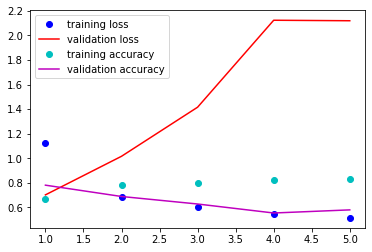

In [143]:
# 전이학습 실행
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH)

# 반환 받은 정확도가 가장 높았던 모델을 torch.save 이용해서 저장 (모델 별로 이름 변경해서 저장!)
torch.save(model, '/content/drive/MyDrive/plant-leaf-dataset/efficientnet_b0.pt')

### 7. 모델 평가

In [144]:
# 전이학습 평가 전처리 (위에서 설명한 것과 동일)
data_transforms = transforms.Compose([ 
        transforms.Resize([64,64]),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

#경로 맞춰서 변경해 주세요!
test_dataset = ImageFolder(root='/content/drive/MyDrive/plant-leaf-dataset/plant-leaf-new-dataset/test', transform=data_transforms) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# 모델 평가 함수
def evaluate(model, test_loader):
    model.eval() #모델을 평가 모드로 설정
    test_loss = 0 #미니 배치 별로 loss를 합산해서 저장
    correct = 0 #정확하게 예측한 수 저장   
    with torch.no_grad(): #해당 메서드를 이용해서 parameter 업데이트 방지
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE) #데이터와 라벨을 불러오면서 gpu에 태움  
            output = model(data) #데이터를 모델에 입력           
            test_loss += torch.nn.functional.cross_entropy(output,target, reduction='sum').item() #모델의 예측값과 정답값 사이의 loss 계산
            pred = output.max(1, keepdim=True)[1]  #모델에 입력된 데이터가 12개의 클래스에 속할 확률값 출력, 이 중 가장 높은 값의 인덱스를 예측값으로 pred에 저장
            correct += pred.eq(target.view_as(pred)).sum().item() #target.view_as(pred)를 이용해 target의 텐서 구조를 pred의 텐서와 같은 모양으로 재정렬 (모델 만들 때 쓰는 view와 비슷 view는 숫자 직접 지정)
                                                                  #eq는 비교 연산자로 pred와 target.view_as(pred)의 값이 일치하면 1, 일치하지 않으면 0 반환
   
    test_loss /= len(test_loader.dataset) #모든 미니 배치에서 합한 loss값을 배치 수로 나누어 loss값의 평균 구함
    test_accuracy = 100. * correct / len(test_loader.dataset) #마찬가지로 정확도의 평균도 구함
    
    return test_loss, test_accuracy #계산한 Test 데이터의 loss와 정확도 반환

# 전이학습 모델 평가 결과
model=torch.load('/content/drive/MyDrive/plant-leaf-dataset/efficientnet_b0.pt') #torch.load를 이용해서 원하는 모델 불러오기!
test_loss, test_accuracy = evaluate(model, test_loader) #평가 함수 이용해서 Test 데이터에 대한 loss 및 정확도 측정
print('model test acc:  ', test_accuracy) #평가 정확도 출력

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


model test acc:   78.40517241379311


(과제) 한 가지 이상의 변화를 준 후 학습을 돌려서 결과와 함께 간단한 설명을 업로드 해주세요 😀

예시 : 다른 전이학습 모델 사용, freeze 시키는 구간 변화, 직접 짠 모델과의 성능 비교, 데이터 수의 변화, optimizer에 대한 실험, epoch 늘리기, 등등

## **(과제 설명)**

efficientnetb0을 사용하여 학습해보았습니다 !

모델 불러올 때 

model = models.mobilenet_v2(pretrained=True)
model.classifier[1].out_features = len(class_names)

처럼 fc 아웃피쳐 수만 바꿔서 코드 실행시켰는데 오류가 나서 EfficientNet 모듈을 불러왔습니다

Resize를 224,224로 바꿔 학습했을 때 오히려 정확도가 떨어지는 것을 볼 수 있었습니다.
또 epoch과 batch_size를 바꿔가면서 실험했을 때 batch_size는 크게, epoch 수는 작게 하여 학습하는 것이 오히려 정확도가 높게 나오는 것을 볼 수 있었습니다.(위에서의 학습 과정처럼 epoch이 진행될 수록 val_acc가 줄어들고 val_loss는 증가하고 있음)


lr은 1e-5는 학습이 잘 안되고 1e-4은 과적합이 발생하여 중간 정도인 0.0005로 설정하였습니다.

test_acc는 val_acc보다 높은 78.4인 것을 확인할 수 있었습니다.